## Project Description:

The goal is to build a Face Mask Segmentation model which includes building a face detector to locate the position of a face in an image.Here we will predict the boundaries(mask) around the face in a given image.

##Data Description:
WIDER Face Dataset
WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, of which 
images are selected from the publicly available WIDER dataset. 
This dataset have 32,203 images and 393,703 faces are labeled with a high degree of 
variability in scale, pose and occlusion as depicted in the sample images.

In this project, we are given 409 images and around 1000 faces for ease of 
computation.
We will be using transfer learning on an already trained model to build our 
segmenter. We will perform transfer learning on the MobileNet model which is 
already trained to perform image segmentation. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face mask 
segmentation. The output of the model is the face mask segmented data which masks the face in an image.

Dataset given is in form .npy format and it is extracted from wider face-dataset and added in the file 'images.npy'.The file contain details about the image and its masks and so there is no separate csv file for that,also there is no separate train and test data given



## (1) Mounting Google Drive in Colab

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (2) Importing important libraries

In [169]:
%tensorflow_version 2.x
import tensorflow 
tensorflow.__version__

'2.2.0'

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

In [0]:
# Initialize the random number generator
import random
random.seed(0)

import warnings
warnings.filterwarnings("ignore")


## (3)Loading the Dataset

In [0]:
project_path=('/content/drive/My Drive/Module-(Computer Vision)/Project1-Face Mask Segmentation/')

In [173]:
os.chdir(project_path)
os.getcwd()
#Make directory for train data at in your project/lab folder
#use !mkdir function

'/content/drive/My Drive/Module-(Computer Vision)/Project1-Face Mask Segmentation'

In [0]:
data=np.load('images.npy',allow_pickle=True)

.npy is standard binary file format for persisting a single arbitrary NumPy array on disk. The format stores all of the shape and data type information necessary to reconstruct the array correctly even on another machine with a different architecture. The format is designed to be as simple as possible while achieving its limited goals. The implementation is intended to be pure Python and distributed as part of the main numpy package

## (4) Checking one of the sample from the loaded dataset

In [176]:
data.shape

(409, 2)

So the dataset have total 409 images

In [177]:
data[15][0]

array([[[20, 34, 43],
        [21, 35, 44],
        [22, 36, 45],
        ...,
        [16, 25, 32],
        [16, 25, 34],
        [15, 25, 34]],

       [[19, 36, 43],
        [19, 36, 43],
        [20, 37, 44],
        ...,
        [18, 27, 34],
        [19, 28, 35],
        [18, 28, 37]],

       [[18, 37, 43],
        [19, 38, 44],
        [19, 38, 44],
        ...,
        [21, 30, 37],
        [21, 30, 37],
        [20, 30, 39]],

       ...,

       [[27, 37, 46],
        [29, 39, 48],
        [31, 41, 50],
        ...,
        [12, 23, 29],
        [12, 23, 29],
        [12, 23, 29]],

       [[22, 31, 38],
        [24, 33, 40],
        [25, 34, 41],
        ...,
        [12, 23, 29],
        [11, 22, 28],
        [11, 22, 28]],

       [[20, 27, 33],
        [22, 29, 35],
        [22, 29, 35],
        ...,
        [11, 22, 28],
        [11, 22, 28],
        [11, 22, 28]]], dtype=uint8)

In [178]:
data[15][1]

[{'imageHeight': 375,
  'imageWidth': 750,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.26266666666666666, 'y': 0.08266666666666667},
   {'x': 0.3973333333333333, 'y': 0.3893333333333333}]},
 {'imageHeight': 375,
  'imageWidth': 750,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.49866666666666665, 'y': 0.050666666666666665},
   {'x': 0.5973333333333334, 'y': 0.2613333333333333}]},
 {'imageHeight': 375,
  'imageWidth': 750,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6773333333333333, 'y': 0.112},
   {'x': 0.7906666666666666, 'y': 0.368}]}]

From the above we can see the given image height and width and face cordinates

## (5) Defining some necessary parameters

In [0]:
# Alpha a  hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0).Alpha=1 means full MobileNet network is taken, Higher width(Alpha) means more accurate but slower
ALPHA=1

IMAGE_WIDTH=224
IMAGE_HEIGHT=224

# Output Response
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

## (6) Creating Features and Labels

In [0]:
#Here feature is the image
#The label is the mask
#Images will be stored in "X_train" array
#Masks will be stored in "masks" array

import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), HEIGHT_CELLS, WIDTH_CELLS))  
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * WIDTH_CELLS)  
        x2 = int(i["points"][1]['x'] * WIDTH_CELLS)
        y1 = int(i["points"][0]['y'] * HEIGHT_CELLS)
        y2 = int(i["points"][1]['y'] * HEIGHT_CELLS)
        masks[index][y1:y2, x1:x2] = 1

## (7) Checking the shape of X_train and mask array

In [181]:
X_train.shape

(409, 224, 224, 3)

In [182]:
masks.shape

(409, 28, 28)

## (8)Printing a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.83529413 -0.72549021 -0.65490198]
  [-0.82745099 -0.70980394 -0.63921571]
  [-0.81176472 -0.68627453 -0.62352943]
  ...
  [-0.87450981 -0.81960785 -0.77254903]
  [-0.87450981 -0.81960785 -0.75686276]
  [-0.86666667 -0.79607844 -0.73333335]]

 [[-0.8509804  -0.7019608  -0.65490198]
  [-0.8509804  -0.7019608  -0.65490198]
  [-0.83529413 -0.68627453 -0.63921571]
  ...
  [-0.86666667 -0.81176472 -0.7647059 ]
  [-0.84313726 -0.78823531 -0.72549021]
  [-0.83529413 -0.7647059  -0.70980394]]

 [[-0.84313726 -0.67843139 -0.63921571]
  [-0.83529413 -0.67058825 -0.63137257]
  [-0.84313726 -0.67843139 -0.63921571]
  ...
  [-0.85882354 -0.80392158 -0.75686276]
  [-0.81960785 -0.7647059  -0.70980394]
  [-0.81176472 -0.74117649 -0.68627453]]

 ...

 [[-0.71764708 -0.59215689 -0.52941179]
  [-0.7019608  -0.57647061 -0.51372552]
  [-0.69411767 -0.59215689 -0.52156866]
  ...
  [-0.90588236 -0.81960785 -0.77254903]
  [-0.9137255  -0.82745099 -0.78039217]
  [-0.90588236 -0.81960785 -0.77254903]]

 [

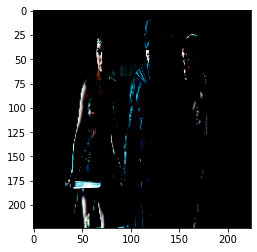

In [183]:
n=15
print(X_train[n])
plt.imshow(X_train[n])


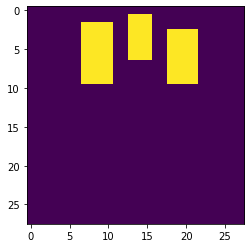

In [184]:
plt.imshow(masks[n])

# Splitting the dataset into 80:20

In [0]:
from sklearn.model_selection import train_test_split
X_train1,X_val,y_train1,y_val=train_test_split(X_train,masks,test_size=0.2,random_state=1)

## (9) Creating the model

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet

 Now lets see the MobileNet architecture so that we can decide which layes to take for doing upsampling

In [187]:
MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3), alpha=ALPHA,include_top=False, weights='imagenet').summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

From the above we can see that when dense layer(top layer) is excluded for MobileNet then also we have 3,206,976 parameters.The current dataset that we have only 409 total images.Now when these many parameters are used for training then definitely it will overfit.So in order to avoid overfitting we will freeze the layers so that these many parameters wont get use and instead we will use weights.We may select the some of layers which have very few parameter and concatenate with upsampling part in U-net.

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Here the encoder we use for our task is pretrained MobileNet, whose some of the intermediate outputs can be used, and the decoder is the upsample block.

Freezing a layer or set of layers means preventing their weights from being
updated during training. If we don’t do this, then the representations that were previously learned by the convolutional base will be modified during training.

Here conv_pw_13_relu,conv_pw_11_relu,conv_pw_5_relu was taken whose parameter are 0 and if we check the shape of it then we can see that conv_pw_13_relu is of shape (7,7,1024),conv_pw_11_relu is of shape (14,14,512).So conv_pw_13_relu is first upsample and then concated with conv_pw_11_relu.Similarly for other also.

## (10) Defining Dice Coefficient

In [0]:
def dice_coefficient(y_true,y_pred):
  numerator=2*tf.reduce_sum(y_true*y_pred)
  denominator=tf.reduce_sum(y_true+y_pred)
  return numerator/(denominator+tensorflow.keras.backend.epsilon())

## (11) Defining Loss Function

In [0]:
def loss(y_true,y_pred):
  return binary_crossentropy(y_true,y_pred)-tf.keras.backend.log(dice_coefficient(y_true,y_pred)+tf.keras.backend.epsilon())

## (12) Let see the model

In [191]:
model=create_model(False)
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_24[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
___________________________________________________________________________________________

From the above we can see that we have less number of parameters (1793) than in compare to previous case.Ler see pictorically how does network architecture looks like below

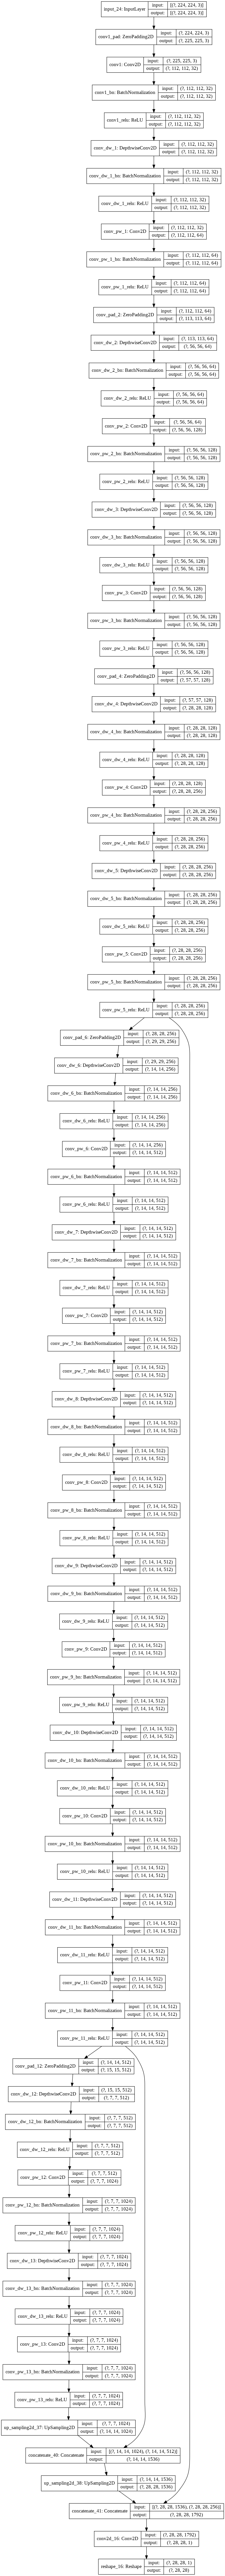

In [192]:
tf.keras.utils.plot_model(model, show_shapes=True)

Clearly we can see some skip connections,these connection will in reataining some of the features which get lost during downsampling.This is one advantage of U-net.

## (13)Compiling the model

In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [0]:
optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coefficient])

## (14) Defining Checkpoint and Earlystopping

In [195]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to fitand that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model.Some of the important callbacks are:

(i)Model checkpoint—is saving the current weights of the model at different points during training.

(ii)Early stopping— is interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).

## (15) Fitting the model

In [196]:
history=model.fit(X_train1,y_train1,validation_data=(X_val,y_val),epochs=5,batch_size=1,callbacks=[checkpoint, reduce_lr, stop])
#model_history=model.fit(X_train1,y_train1,epochs=10,batch_size=1)

Epoch 1/5
325/327 [============================>.] - ETA: 0s - loss: 1.2200 - dice_coefficient: 0.4619
Epoch 00001: loss improved from inf to 1.22146, saving model to model-1.22.h5
327/327 [==============================] - 2s 7ms/step - loss: 1.2215 - dice_coefficient: 0.4622 - val_loss: 1.1086 - val_dice_coefficient: 0.5363 - lr: 0.0010
Epoch 2/5
327/327 [==============================] - ETA: 0s - loss: 0.8631 - dice_coefficient: 0.5701
Epoch 00002: loss improved from 1.22146 to 0.86315, saving model to model-0.86.h5
327/327 [==============================] - 3s 8ms/step - loss: 0.8631 - dice_coefficient: 0.5701 - val_loss: 1.0801 - val_dice_coefficient: 0.5553 - lr: 0.0010
Epoch 3/5
313/327 [===========================>..] - ETA: 0s - loss: 0.7964 - dice_coefficient: 0.5929
Epoch 00003: loss improved from 0.86315 to 0.79725, saving model to model-0.80.h5
327/327 [==============================] - 3s 8ms/step - loss: 0.7972 - dice_coefficient: 0.5933 - val_loss: 1.0966 - val_dice_co

In [0]:
#Let see the plot of loss with epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']

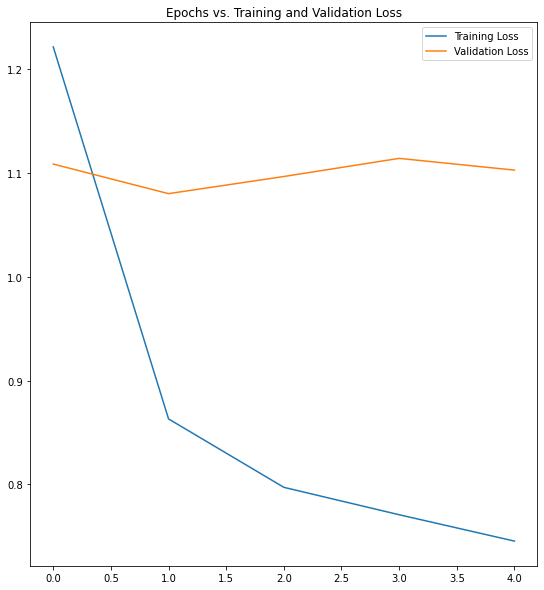

In [198]:
# Visualize epochs vs. train and validation losses

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

From the above we can clearly see that data is overfitting and this happens because we have too small datasets (409 total images) and trainable parameters is in thousands.This overfitting we can further reduce by using some image augmentation techniques which will generate further additional images.

## (16)Get the predicted mask for sample image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


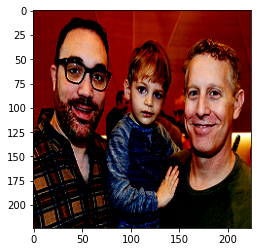

In [199]:
n=2
sample_image=X_val[n]
plt.imshow(X_val[n])

The above is the actual image we have in the dataset

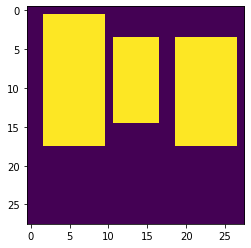

In [200]:
plt.imshow(y_val[n])

Above shows actual mask of the image we have in the dataset,let now see its corresponding predicted mask

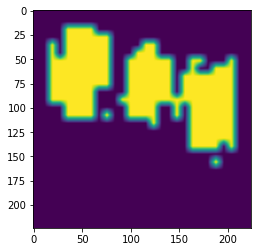

In [201]:
import matplotlib.pyplot as plt

image=sample_image
#Here we dont need to resize as already sample image is in array and no need to preprocess it also
#image = cv2.resize(image, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC)
#feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
feat_scaled=image
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(pred_mask)

## (17)Imposing the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


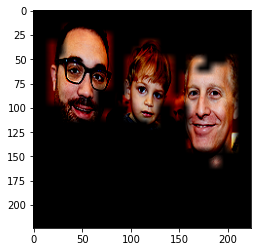

In [202]:
image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2
plt.imshow(out_image)

# Conclusion:

(1)In image classification the task of the network is to assign a label or class to an input image.

(2)If we want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. then in that case we will segment the image, i.e., each pixel of the image is given a label. 

(3)The task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

(4)A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A pretrained networkis a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

(5) The spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computervision problems.

(6) Freezinga layer or set of layers means preventing their weights from being
updated during training.

(7)Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier)
and these top layers.